In this notebook I'll reconstruct the process and results of the DTCR algorithm presented in the "Learning Representations for Time Series Clustering".

In [1]:
# Imports
import torch
from torch.utils.data import DataLoader
from Utilities.DTCR import DTCRModel, DTCRConfig
from Utilities.UCRParser import read_dataset

In [ ]:
testing_dataset = "Symbols"
train_ds, test_ds = read_dataset(testing_dataset)

config = DTCRConfig()
config.class_num = train_ds.number_of_labels
config.input_size = train_ds[0][0].shape[1]
config.num_steps = train_ds[0][0].shape[0]
config.model_name = testing_dataset
config.batch_size = len(train_ds)

config.learning_rate = 8e-5
config.checkpoint_interval = 50
config.hidden_size = [50, 30, 30]
config.dilations = [1, 4, 16]
config.coefficient_lambda = 0.1

train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

Loading the ECGFiveDays dataset...
The dataset ECGFiveDays was loaded.


In [ ]:
dtcr_model = DTCRModel(config)
dtcr_model

DTCRModel(
  (encoder): BidirectionalDRNN(
    (_regular_drnn): DRNN(
      (_layers): ModuleList(
        (0): GRU(1, 50, batch_first=True)
        (1): GRU(50, 30, batch_first=True)
        (2): GRU(30, 30, batch_first=True)
      )
    )
    (_backwards_drnn): DRNN(
      (_layers): ModuleList(
        (0): GRU(1, 50, batch_first=True)
        (1): GRU(50, 30, batch_first=True)
        (2): GRU(30, 30, batch_first=True)
      )
    )
  )
  (decoder): DTCRDecoder(
    (_rnn): GRU(220, 220, batch_first=True)
    (_linear): Linear(in_features=220, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=220, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)

In [ ]:
# if you want to continue the training load the model here from the checkpoint
# dtcr_model = torch.load("Checkpoints/ECGFiveDays_900")
recons_criterion = config.decoding_criterion()
classify_criterion = config.classifier_criterion()
optimizer = config.optimizer(dtcr_model.parameters(),
                             eps=config.learning_rate)

Starting epoch 1:
[1|1] loss: 9.4888, classify: 0.69331,recons: 0.99407, clustering: 78.01384
Starting epoch 2:
[2|1] loss: 8.6602, classify: 0.69271,recons: 0.99923, clustering: 69.68271
Starting epoch 3:
[3|1] loss: 7.9484, classify: 0.69295,recons: 0.99309, clustering: 62.62333
Starting epoch 4:
[4|1] loss: 7.3501, classify: 0.69256,recons: 0.99315, clustering: 56.64414
Starting epoch 5:
[5|1] loss: 6.8498, classify: 0.69290,recons: 0.99429, clustering: 51.62583
Starting epoch 6:
[6|1] loss: 6.4073, classify: 0.69242,recons: 0.99397, clustering: 47.20939
Starting epoch 7:
[7|1] loss: 6.0451, classify: 0.69399,recons: 0.99296, clustering: 43.58118
Starting epoch 8:
[8|1] loss: 5.7236, classify: 0.69177,recons: 0.99231, clustering: 40.39532
Starting epoch 9:
[9|1] loss: 5.4176, classify: 0.69347,recons: 0.99235, clustering: 37.31732
Starting epoch 10:
[10|1] loss: 5.1922, classify: 0.69120,recons: 0.99275, clustering: 35.08199
Starting epoch 11:
[11|1] loss: 1.8590, classify: 0.69214,

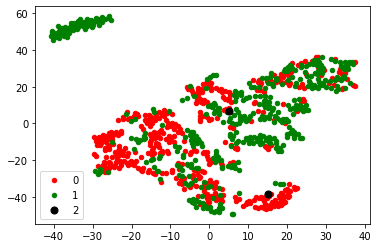

Plot with predicted labels (for kmeans and tsne sanity):


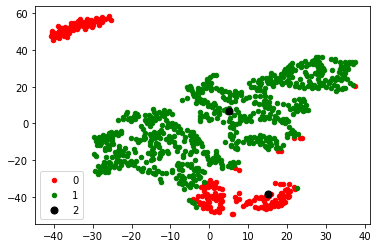

Starting epoch 51:
[51|1] loss: 1.7456, classify: 0.68755,recons: 0.99147, clustering: 0.66634
Starting epoch 52:
[52|1] loss: 1.7454, classify: 0.69036,recons: 0.99145, clustering: 0.63597
Starting epoch 53:
[53|1] loss: 1.7344, classify: 0.67904,recons: 0.99146, clustering: 0.63921
Starting epoch 54:
[54|1] loss: 1.7376, classify: 0.68484,recons: 0.99142, clustering: 0.61341
Starting epoch 55:
[55|1] loss: 1.7450, classify: 0.69174,recons: 0.99142, clustering: 0.61841
Starting epoch 56:
[56|1] loss: 1.7383, classify: 0.68636,recons: 0.99141, clustering: 0.60558
Starting epoch 57:
[57|1] loss: 1.7407, classify: 0.68994,recons: 0.99137, clustering: 0.59393
Starting epoch 58:
[58|1] loss: 1.7336, classify: 0.69122,recons: 0.99137, clustering: 0.51058
Starting epoch 59:
[59|1] loss: 1.7347, classify: 0.68748,recons: 0.99132, clustering: 0.55942
Starting epoch 60:
[60|1] loss: 1.7304, classify: 0.68541,recons: 0.99131, clustering: 0.53721
Starting epoch 61:
[61|1] loss: 1.7222, classify: 

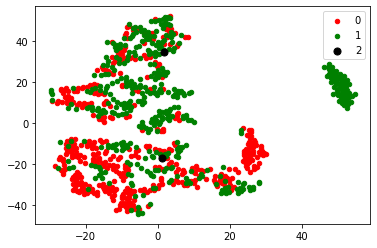

Plot with predicted labels (for kmeans and tsne sanity):


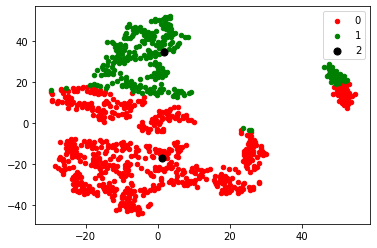

Starting epoch 101:
[101|1] loss: 1.7118, classify: 0.69219,recons: 0.99203, clustering: 0.27524
Starting epoch 102:
[102|1] loss: 1.7059, classify: 0.68868,recons: 0.99206, clustering: 0.25186
Starting epoch 103:
[103|1] loss: 1.6989, classify: 0.68025,recons: 0.99206, clustering: 0.26630
Starting epoch 104:
[104|1] loss: 1.7046, classify: 0.68898,recons: 0.99205, clustering: 0.23588
Starting epoch 105:
[105|1] loss: 1.7008, classify: 0.68323,recons: 0.99202, clustering: 0.25601
Starting epoch 106:
[106|1] loss: 1.6952, classify: 0.67744,recons: 0.99199, clustering: 0.25775
Starting epoch 107:
[107|1] loss: 1.6954, classify: 0.67889,recons: 0.99197, clustering: 0.24503
Starting epoch 108:
[108|1] loss: 1.6929, classify: 0.67664,recons: 0.99196, clustering: 0.24269
Starting epoch 109:
[109|1] loss: 1.6894, classify: 0.67359,recons: 0.99196, clustering: 0.23882
Starting epoch 110:
[110|1] loss: 1.6973, classify: 0.68071,recons: 0.99197, clustering: 0.24640
Starting epoch 111:
[111|1] lo

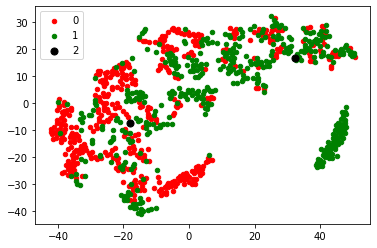

Plot with predicted labels (for kmeans and tsne sanity):


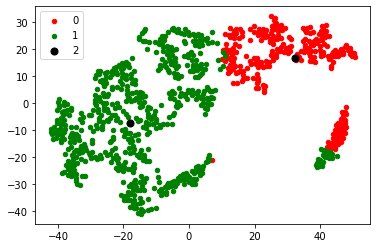

Starting epoch 151:
[151|1] loss: 1.6777, classify: 0.67147,recons: 0.99188, clustering: 0.14358
Starting epoch 152:
[152|1] loss: 1.6836, classify: 0.67656,recons: 0.99188, clustering: 0.15142
Starting epoch 153:
[153|1] loss: 1.6642, classify: 0.65796,recons: 0.99188, clustering: 0.14358
Starting epoch 154:
[154|1] loss: 1.6765, classify: 0.67027,recons: 0.99187, clustering: 0.14314
Starting epoch 155:
[155|1] loss: 1.6905, classify: 0.68432,recons: 0.99187, clustering: 0.14320
Starting epoch 156:
[156|1] loss: 1.6777, classify: 0.67126,recons: 0.99187, clustering: 0.14616
Starting epoch 157:
[157|1] loss: 1.6639, classify: 0.65766,recons: 0.99187, clustering: 0.14361
Starting epoch 158:
[158|1] loss: 1.6699, classify: 0.66366,recons: 0.99187, clustering: 0.14390
Starting epoch 159:
[159|1] loss: 1.6831, classify: 0.67711,recons: 0.99187, clustering: 0.14128
Starting epoch 160:
[160|1] loss: 1.6709, classify: 0.66500,recons: 0.99186, clustering: 0.13989
Starting epoch 161:
[161|1] lo

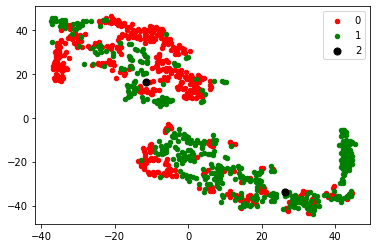

Plot with predicted labels (for kmeans and tsne sanity):


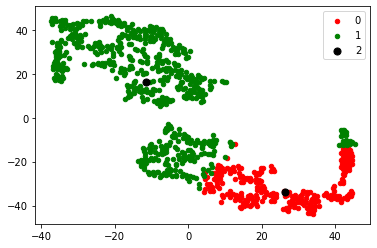

Starting epoch 201:
[201|1] loss: 1.6489, classify: 0.64540,recons: 0.99182, clustering: 0.11735
Starting epoch 202:
[202|1] loss: 1.6500, classify: 0.64661,recons: 0.99182, clustering: 0.11566
Starting epoch 203:
[203|1] loss: 1.6942, classify: 0.69080,recons: 0.99181, clustering: 0.11605
Starting epoch 204:
[204|1] loss: 1.6948, classify: 0.69173,recons: 0.99181, clustering: 0.11247
Starting epoch 205:
[205|1] loss: 1.6512, classify: 0.64804,recons: 0.99181, clustering: 0.11363
Starting epoch 206:
[206|1] loss: 1.6335, classify: 0.63023,recons: 0.99181, clustering: 0.11481
Starting epoch 207:
[207|1] loss: 1.6477, classify: 0.64466,recons: 0.99181, clustering: 0.11181
Starting epoch 208:
[208|1] loss: 1.6634, classify: 0.66038,recons: 0.99181, clustering: 0.11254
Starting epoch 209:
[209|1] loss: 1.6644, classify: 0.66467,recons: 0.99181, clustering: 0.07922
Starting epoch 210:
[210|1] loss: 1.6452, classify: 0.64317,recons: 0.99181, clustering: 0.10218
Starting epoch 211:
[211|1] lo

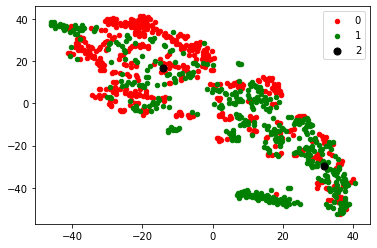

Plot with predicted labels (for kmeans and tsne sanity):


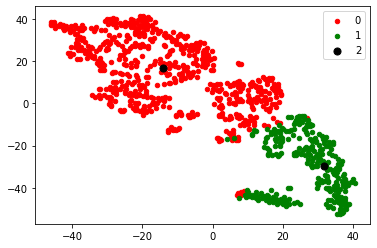

Starting epoch 251:
[251|1] loss: 1.5568, classify: 0.55178,recons: 0.99179, clustering: 0.13238
Starting epoch 252:
[252|1] loss: 1.5113, classify: 0.50570,recons: 0.99179, clustering: 0.13794
Starting epoch 253:
[253|1] loss: 1.5189, classify: 0.51303,recons: 0.99179, clustering: 0.14112
Starting epoch 254:
[254|1] loss: 1.5238, classify: 0.51630,recons: 0.99179, clustering: 0.15673
Starting epoch 255:
[255|1] loss: 1.4663, classify: 0.45747,recons: 0.99178, clustering: 0.17061
Starting epoch 256:
[256|1] loss: 1.4561, classify: 0.44559,recons: 0.99178, clustering: 0.18713
Starting epoch 257:
[257|1] loss: 1.4665, classify: 0.45355,recons: 0.99178, clustering: 0.21125
Starting epoch 258:
[258|1] loss: 1.4892, classify: 0.47281,recons: 0.99178, clustering: 0.24566
Starting epoch 259:
[259|1] loss: 1.4358, classify: 0.41534,recons: 0.99177, clustering: 0.28655
Starting epoch 260:
[260|1] loss: 1.4285, classify: 0.40806,recons: 0.99177, clustering: 0.28650
Starting epoch 261:
[261|1] lo

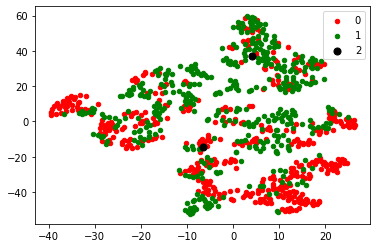

Plot with predicted labels (for kmeans and tsne sanity):


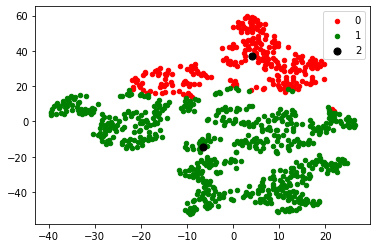

Starting epoch 301:
[301|1] loss: 1.3313, classify: 0.31983,recons: 0.99178, clustering: 0.19687
Starting epoch 302:
[302|1] loss: 1.3271, classify: 0.31545,recons: 0.99177, clustering: 0.19867
Starting epoch 303:
[303|1] loss: 1.4529, classify: 0.44304,recons: 0.99177, clustering: 0.18062
Starting epoch 304:
[304|1] loss: 1.3418, classify: 0.33204,recons: 0.99177, clustering: 0.18024
Starting epoch 305:
[305|1] loss: 1.3348, classify: 0.32355,recons: 0.99178, clustering: 0.19429
Starting epoch 306:
[306|1] loss: 1.3503, classify: 0.34046,recons: 0.99178, clustering: 0.18039
Starting epoch 307:
[307|1] loss: 1.3433, classify: 0.33264,recons: 0.99178, clustering: 0.18834
Starting epoch 308:
[308|1] loss: 1.3468, classify: 0.33583,recons: 0.99177, clustering: 0.19166
Starting epoch 309:
[309|1] loss: 1.3518, classify: 0.34090,recons: 0.99177, clustering: 0.19167
Starting epoch 310:
[310|1] loss: 1.3264, classify: 0.31684,recons: 0.99177, clustering: 0.17818
Starting epoch 311:
[311|1] lo

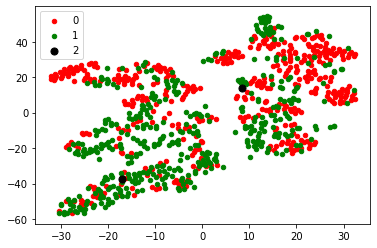

Plot with predicted labels (for kmeans and tsne sanity):


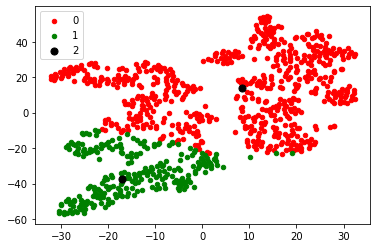

Starting epoch 351:
[351|1] loss: 1.4697, classify: 0.45687,recons: 0.99174, clustering: 0.21085
Starting epoch 352:
[352|1] loss: 1.4226, classify: 0.40981,recons: 0.99174, clustering: 0.21070
Starting epoch 353:
[353|1] loss: 1.4793, classify: 0.46533,recons: 0.99174, clustering: 0.22224
Starting epoch 354:
[354|1] loss: 1.4598, classify: 0.44760,recons: 0.99174, clustering: 0.20494
Starting epoch 355:
[355|1] loss: 1.4433, classify: 0.43234,recons: 0.99175, clustering: 0.19168
Starting epoch 356:
[356|1] loss: 1.3646, classify: 0.35734,recons: 0.99176, clustering: 0.15456
Starting epoch 357:
[357|1] loss: 1.3283, classify: 0.31533,recons: 0.99178, clustering: 0.21202
Starting epoch 358:
[358|1] loss: 1.6180, classify: 0.60122,recons: 0.99180, clustering: 0.24949
Starting epoch 359:
[359|1] loss: 1.3291, classify: 0.31555,recons: 0.99177, clustering: 0.21789
Starting epoch 360:
[360|1] loss: 1.4541, classify: 0.44216,recons: 0.99175, clustering: 0.20179
Starting epoch 361:
[361|1] lo

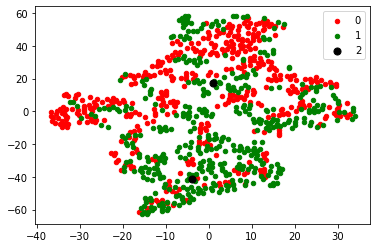

Plot with predicted labels (for kmeans and tsne sanity):


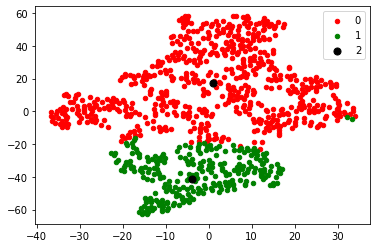

Starting epoch 401:
[401|1] loss: 1.3376, classify: 0.32484,recons: 0.99171, clustering: 0.21062
Starting epoch 402:
[402|1] loss: 1.3323, classify: 0.31984,recons: 0.99171, clustering: 0.20726
Starting epoch 403:
[403|1] loss: 1.3387, classify: 0.32734,recons: 0.99170, clustering: 0.19643
Starting epoch 404:
[404|1] loss: 1.3298, classify: 0.31738,recons: 0.99169, clustering: 0.20779
Starting epoch 405:
[405|1] loss: 1.3310, classify: 0.31924,recons: 0.99168, clustering: 0.20069
Starting epoch 406:
[406|1] loss: 1.3250, classify: 0.31389,recons: 0.99167, clustering: 0.19390
Starting epoch 407:
[407|1] loss: 1.3251, classify: 0.31365,recons: 0.99166, clustering: 0.19741
Starting epoch 408:
[408|1] loss: 1.3368, classify: 0.32607,recons: 0.99164, clustering: 0.19106
Starting epoch 409:
[409|1] loss: 1.3244, classify: 0.31370,recons: 0.99163, clustering: 0.19026
Starting epoch 410:
[410|1] loss: 1.3247, classify: 0.31367,recons: 0.99161, clustering: 0.19419
Starting epoch 411:
[411|1] lo

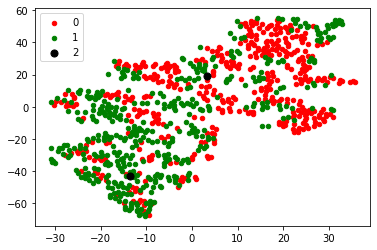

Plot with predicted labels (for kmeans and tsne sanity):


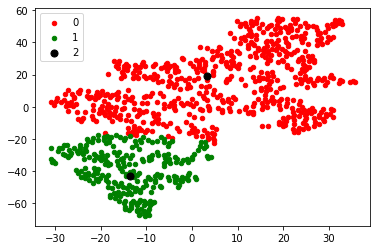

Starting epoch 451:
[451|1] loss: 1.3276, classify: 0.31591,recons: 0.99492, clustering: 0.16816
Starting epoch 452:
[452|1] loss: 1.3208, classify: 0.31791,recons: 0.98610, clustering: 0.16759
Starting epoch 453:
[453|1] loss: 1.3661, classify: 0.31552,recons: 1.03385, clustering: 0.16748
Starting epoch 454:
[454|1] loss: 1.3144, classify: 0.31478,recons: 0.98320, clustering: 0.16386
Starting epoch 455:
[455|1] loss: 1.3220, classify: 0.31428,recons: 0.99187, clustering: 0.15842
Starting epoch 456:
[456|1] loss: 1.3329, classify: 0.31388,recons: 1.00289, clustering: 0.16153
Starting epoch 457:
[457|1] loss: 1.3305, classify: 0.31803,recons: 1.00136, clustering: 0.11151
Starting epoch 458:
[458|1] loss: 1.3178, classify: 0.31370,recons: 0.98788, clustering: 0.16210
Starting epoch 459:
[459|1] loss: 1.3222, classify: 0.33104,recons: 0.97498, clustering: 0.16161
Starting epoch 460:
[460|1] loss: 1.3242, classify: 0.31383,recons: 0.99443, clustering: 0.15962
Starting epoch 461:
[461|1] lo

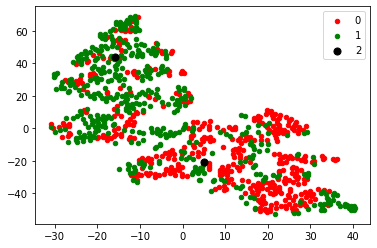

Plot with predicted labels (for kmeans and tsne sanity):


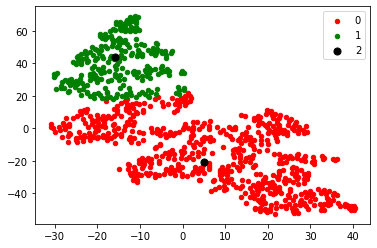

Starting epoch 501:
[501|1] loss: 1.3207, classify: 0.31346,recons: 0.99268, clustering: 0.14557
Starting epoch 502:
[502|1] loss: 1.3208, classify: 0.31345,recons: 0.99257, clustering: 0.14826
Starting epoch 503:
[503|1] loss: 1.3254, classify: 0.31827,recons: 0.99248, clustering: 0.14656
Starting epoch 504:
[504|1] loss: 1.3407, classify: 0.33423,recons: 0.99241, clustering: 0.14065
Starting epoch 505:
[505|1] loss: 1.3206, classify: 0.31354,recons: 0.99235, clustering: 0.14762
Starting epoch 506:
[506|1] loss: 1.3201, classify: 0.31364,recons: 0.99230, clustering: 0.14165
Starting epoch 507:
[507|1] loss: 1.3202, classify: 0.31376,recons: 0.99226, clustering: 0.14167
Starting epoch 508:
[508|1] loss: 1.3205, classify: 0.31400,recons: 0.99223, clustering: 0.14254
Starting epoch 509:
[509|1] loss: 1.3203, classify: 0.31399,recons: 0.99221, clustering: 0.14059
Starting epoch 510:
[510|1] loss: 1.3224, classify: 0.31541,recons: 0.99220, clustering: 0.14778
Starting epoch 511:
[511|1] lo

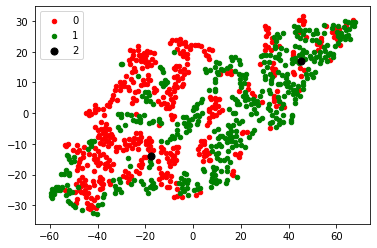

Plot with predicted labels (for kmeans and tsne sanity):


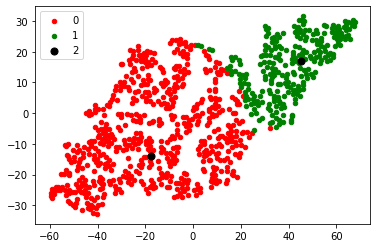

Starting epoch 551:
[551|1] loss: 1.3248, classify: 0.31812,recons: 0.99217, clustering: 0.14504
Starting epoch 552:
[552|1] loss: 1.3211, classify: 0.31526,recons: 0.99217, clustering: 0.13632
Starting epoch 553:
[553|1] loss: 1.3414, classify: 0.33578,recons: 0.99217, clustering: 0.13478
Starting epoch 554:
[554|1] loss: 1.3202, classify: 0.31397,recons: 0.99217, clustering: 0.14104
Starting epoch 555:
[555|1] loss: 1.3418, classify: 0.33518,recons: 0.99217, clustering: 0.14449
Starting epoch 556:
[556|1] loss: 1.3205, classify: 0.31377,recons: 0.99216, clustering: 0.14610
Starting epoch 557:
[557|1] loss: 1.3216, classify: 0.31362,recons: 0.99216, clustering: 0.15856
Starting epoch 558:
[558|1] loss: 1.3218, classify: 0.31358,recons: 0.99216, clustering: 0.16061
Starting epoch 559:
[559|1] loss: 1.3207, classify: 0.31356,recons: 0.99216, clustering: 0.14989
Starting epoch 560:
[560|1] loss: 1.3211, classify: 0.31358,recons: 0.99216, clustering: 0.15355
Starting epoch 561:
[561|1] lo

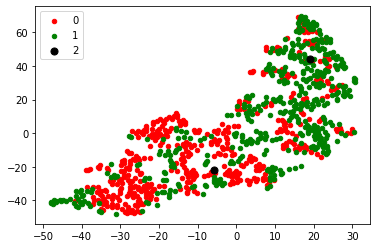

Plot with predicted labels (for kmeans and tsne sanity):


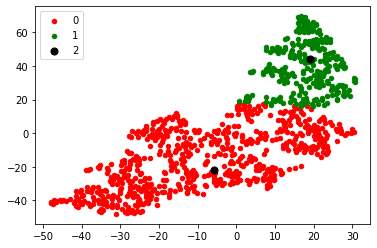

Starting epoch 601:
[601|1] loss: 1.3397, classify: 0.33534,recons: 0.99212, clustering: 0.12265
Starting epoch 602:
[602|1] loss: 1.3382, classify: 0.33415,recons: 0.99212, clustering: 0.11913
Starting epoch 603:
[603|1] loss: 1.3365, classify: 0.33225,recons: 0.99212, clustering: 0.12090
Starting epoch 604:
[604|1] loss: 1.3180, classify: 0.31337,recons: 0.99212, clustering: 0.12563
Starting epoch 605:
[605|1] loss: 1.3178, classify: 0.31340,recons: 0.99212, clustering: 0.12293
Starting epoch 606:
[606|1] loss: 1.3181, classify: 0.31345,recons: 0.99212, clustering: 0.12521
Starting epoch 607:
[607|1] loss: 1.3184, classify: 0.31353,recons: 0.99212, clustering: 0.12780
Starting epoch 608:
[608|1] loss: 1.3332, classify: 0.32894,recons: 0.99211, clustering: 0.12181
Starting epoch 609:
[609|1] loss: 1.3183, classify: 0.31402,recons: 0.99212, clustering: 0.12166
Starting epoch 610:
[610|1] loss: 1.3363, classify: 0.33171,recons: 0.99212, clustering: 0.12505
Starting epoch 611:
[611|1] lo

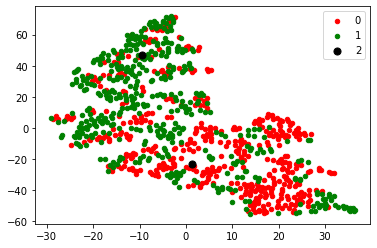

Plot with predicted labels (for kmeans and tsne sanity):


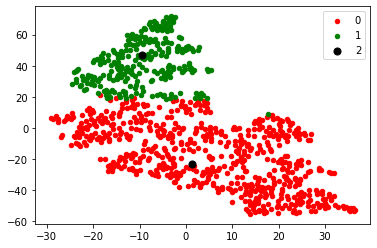

Starting epoch 651:
[651|1] loss: 1.3212, classify: 0.31745,recons: 0.99208, clustering: 0.11692
Starting epoch 652:
[652|1] loss: 1.3288, classify: 0.32510,recons: 0.99208, clustering: 0.11659
Starting epoch 653:
[653|1] loss: 1.3206, classify: 0.31660,recons: 0.99208, clustering: 0.11885
Starting epoch 654:
[654|1] loss: 1.3307, classify: 0.32636,recons: 0.99208, clustering: 0.12311
Starting epoch 655:
[655|1] loss: 1.3183, classify: 0.31470,recons: 0.99207, clustering: 0.11541
Starting epoch 656:
[656|1] loss: 1.3230, classify: 0.31904,recons: 0.99207, clustering: 0.11859
Starting epoch 657:
[657|1] loss: 1.3177, classify: 0.31341,recons: 0.99207, clustering: 0.12260
Starting epoch 658:
[658|1] loss: 1.3175, classify: 0.31339,recons: 0.99207, clustering: 0.12050
Starting epoch 659:
[659|1] loss: 1.3191, classify: 0.31390,recons: 0.99207, clustering: 0.13153
Starting epoch 660:
[660|1] loss: 1.3179, classify: 0.31333,recons: 0.99207, clustering: 0.12502
Starting epoch 661:
[661|1] lo

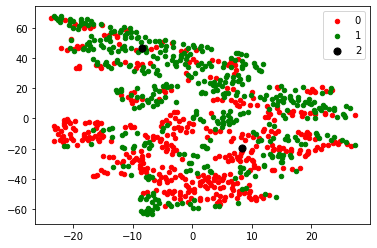

Plot with predicted labels (for kmeans and tsne sanity):


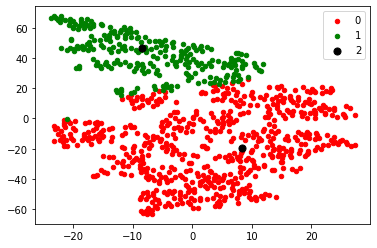

Starting epoch 701:
[701|1] loss: 1.3165, classify: 0.31351,recons: 0.99203, clustering: 0.10997
Starting epoch 702:
[702|1] loss: 1.3163, classify: 0.31341,recons: 0.99203, clustering: 0.10871
Starting epoch 703:
[703|1] loss: 1.3165, classify: 0.31337,recons: 0.99203, clustering: 0.11121
Starting epoch 704:
[704|1] loss: 1.3178, classify: 0.31455,recons: 0.99202, clustering: 0.11241
Starting epoch 705:
[705|1] loss: 1.3147, classify: 0.31333,recons: 0.99202, clustering: 0.09317
Starting epoch 706:
[706|1] loss: 1.3165, classify: 0.31332,recons: 0.99202, clustering: 0.11187
Starting epoch 707:
[707|1] loss: 1.3160, classify: 0.31338,recons: 0.99202, clustering: 0.10556
Starting epoch 708:
[708|1] loss: 1.3381, classify: 0.33608,recons: 0.99202, clustering: 0.09983
Starting epoch 709:
[709|1] loss: 1.3167, classify: 0.31379,recons: 0.99202, clustering: 0.10935
Starting epoch 710:
[710|1] loss: 1.3304, classify: 0.32743,recons: 0.99202, clustering: 0.10989
Starting epoch 711:
[711|1] lo

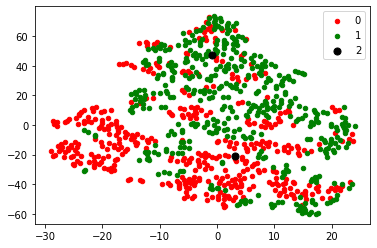

Plot with predicted labels (for kmeans and tsne sanity):


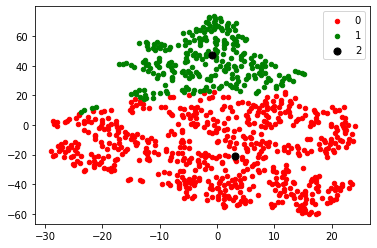

Starting epoch 751:
[751|1] loss: 1.3263, classify: 0.32323,recons: 0.99198, clustering: 0.11129
Starting epoch 752:
[752|1] loss: 1.3194, classify: 0.31643,recons: 0.99198, clustering: 0.10955
Starting epoch 753:
[753|1] loss: 1.3166, classify: 0.31371,recons: 0.99198, clustering: 0.10931
Starting epoch 754:
[754|1] loss: 1.3168, classify: 0.31340,recons: 0.99198, clustering: 0.11443
Starting epoch 755:
[755|1] loss: 1.3180, classify: 0.31365,recons: 0.99198, clustering: 0.12364
Starting epoch 756:
[756|1] loss: 1.3185, classify: 0.31342,recons: 0.99198, clustering: 0.13083
Starting epoch 757:
[757|1] loss: 1.3210, classify: 0.31638,recons: 0.99197, clustering: 0.12641
Starting epoch 758:
[758|1] loss: 1.3188, classify: 0.31329,recons: 0.99197, clustering: 0.13509
Starting epoch 759:
[759|1] loss: 1.3187, classify: 0.31399,recons: 0.99197, clustering: 0.12710
Starting epoch 760:
[760|1] loss: 1.3181, classify: 0.31365,recons: 0.99197, clustering: 0.12453
Starting epoch 761:
[761|1] lo

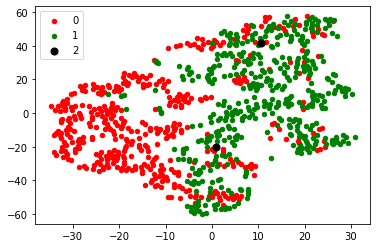

Plot with predicted labels (for kmeans and tsne sanity):


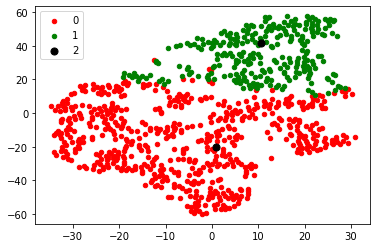

Starting epoch 801:
[801|1] loss: 1.3275, classify: 0.31330,recons: 0.99191, clustering: 0.22313
Starting epoch 802:
[802|1] loss: 1.3446, classify: 0.32408,recons: 0.99192, clustering: 0.28565
Starting epoch 803:
[803|1] loss: 1.3403, classify: 0.32428,recons: 0.99192, clustering: 0.24139
Starting epoch 804:
[804|1] loss: 1.3223, classify: 0.31337,recons: 0.99193, clustering: 0.16973
Starting epoch 805:
[805|1] loss: 1.3170, classify: 0.31329,recons: 0.99193, clustering: 0.11745
Starting epoch 806:
[806|1] loss: 1.3250, classify: 0.31327,recons: 0.99193, clustering: 0.19757
Starting epoch 807:
[807|1] loss: 1.3311, classify: 0.31327,recons: 0.99193, clustering: 0.25933
Starting epoch 808:
[808|1] loss: 1.3347, classify: 0.31327,recons: 0.99193, clustering: 0.29552
Starting epoch 809:
[809|1] loss: 1.3375, classify: 0.31326,recons: 0.99193, clustering: 0.32279
Starting epoch 810:
[810|1] loss: 1.3589, classify: 0.33497,recons: 0.99192, clustering: 0.31974
Starting epoch 811:
[811|1] lo

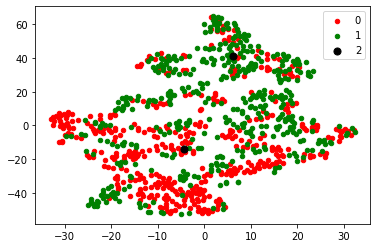

Plot with predicted labels (for kmeans and tsne sanity):


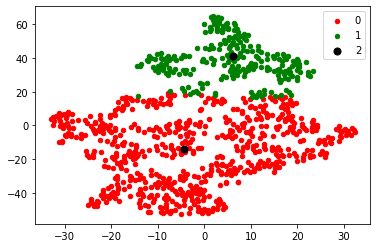

Starting epoch 851:
[851|1] loss: 1.3178, classify: 0.31327,recons: 0.99188, clustering: 0.12609
Starting epoch 852:
[852|1] loss: 1.3185, classify: 0.31327,recons: 0.99188, clustering: 0.13344
Starting epoch 853:
[853|1] loss: 1.3121, classify: 0.31326,recons: 0.99187, clustering: 0.06946
Starting epoch 854:
[854|1] loss: 1.3449, classify: 0.33979,recons: 0.99187, clustering: 0.13217
Starting epoch 855:
[855|1] loss: 1.3396, classify: 0.33500,recons: 0.99187, clustering: 0.12733
Starting epoch 856:
[856|1] loss: 1.3171, classify: 0.31327,recons: 0.99187, clustering: 0.11980
Starting epoch 857:
[857|1] loss: 1.3178, classify: 0.31327,recons: 0.99187, clustering: 0.12691
Starting epoch 858:
[858|1] loss: 1.3169, classify: 0.31328,recons: 0.99187, clustering: 0.11742
Starting epoch 859:
[859|1] loss: 1.3176, classify: 0.31327,recons: 0.99187, clustering: 0.12503
Starting epoch 860:
[860|1] loss: 1.3173, classify: 0.31327,recons: 0.99187, clustering: 0.12125
Starting epoch 861:
[861|1] lo

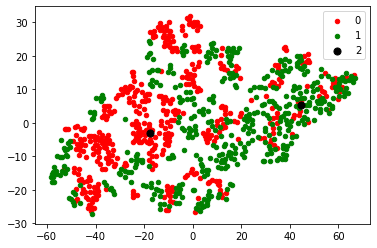

Plot with predicted labels (for kmeans and tsne sanity):


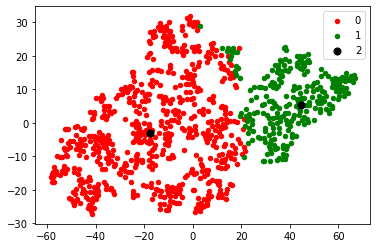

Starting epoch 901:
[901|1] loss: 1.3169, classify: 0.31420,recons: 0.99184, clustering: 0.10808
Starting epoch 902:
[902|1] loss: 1.3168, classify: 0.31420,recons: 0.99184, clustering: 0.10710
Starting epoch 903:
[903|1] loss: 1.3169, classify: 0.31395,recons: 0.99184, clustering: 0.11085
Starting epoch 904:
[904|1] loss: 1.3134, classify: 0.31368,recons: 0.99184, clustering: 0.07843
Starting epoch 905:
[905|1] loss: 1.3163, classify: 0.31352,recons: 0.99184, clustering: 0.10895
Starting epoch 906:
[906|1] loss: 1.3353, classify: 0.33272,recons: 0.99184, clustering: 0.10759
Starting epoch 907:
[907|1] loss: 1.3160, classify: 0.31351,recons: 0.99184, clustering: 0.10624
Starting epoch 908:
[908|1] loss: 1.3159, classify: 0.31344,recons: 0.99184, clustering: 0.10585
Starting epoch 909:
[909|1] loss: 1.3160, classify: 0.31344,recons: 0.99184, clustering: 0.10718
Starting epoch 910:
[910|1] loss: 1.3159, classify: 0.31344,recons: 0.99183, clustering: 0.10583
Starting epoch 911:
[911|1] lo

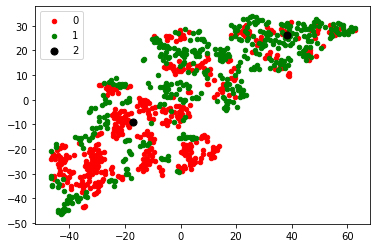

Plot with predicted labels (for kmeans and tsne sanity):


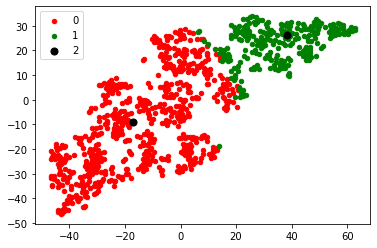

Starting epoch 951:
[951|1] loss: 1.3149, classify: 0.31335,recons: 0.99178, clustering: 0.09724
Starting epoch 952:
[952|1] loss: 1.3148, classify: 0.31335,recons: 0.99178, clustering: 0.09649
Starting epoch 953:
[953|1] loss: 1.3149, classify: 0.31335,recons: 0.99178, clustering: 0.09748
Starting epoch 954:
[954|1] loss: 1.3146, classify: 0.31334,recons: 0.99177, clustering: 0.09466
Starting epoch 955:
[955|1] loss: 1.3148, classify: 0.31334,recons: 0.99177, clustering: 0.09665
Starting epoch 956:
[956|1] loss: 1.3148, classify: 0.31334,recons: 0.99177, clustering: 0.09646
Starting epoch 957:
[957|1] loss: 1.3215, classify: 0.31994,recons: 0.99177, clustering: 0.09802
Starting epoch 958:
[958|1] loss: 1.3143, classify: 0.31339,recons: 0.99177, clustering: 0.09176
Starting epoch 959:
[959|1] loss: 1.3150, classify: 0.31354,recons: 0.99177, clustering: 0.09688
Starting epoch 960:
[960|1] loss: 1.3154, classify: 0.31390,recons: 0.99177, clustering: 0.09771
Starting epoch 961:
[961|1] lo

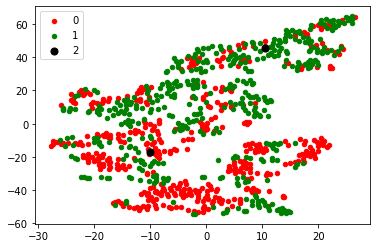

Plot with predicted labels (for kmeans and tsne sanity):


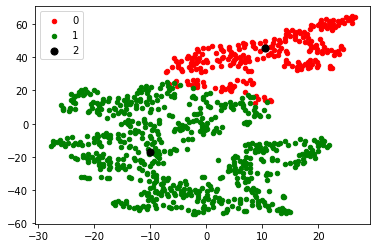

In [ ]:
epochs = 1500
for epoch in range(dtcr_model._training_iteration, epochs):
    print("Starting epoch {}:".format(epoch + 1))
    dtcr_model.train_step(train_dl, test_dl, recons_criterion, classify_criterion,
                          optimizer)